In [1]:
%load_ext autoreload 
%autoreload 2

NB: to beat / get comparable to fb results, need R^2 values between 0.56 (spatial CV), 0.59 (leave country out), and 0.7 (conventional CV). They construct spatial CV as follows: 

    In each country, we select a random cell as the training centroid, then define the  training dataset as the nearest (k-1)/k percent of cells to that centroid. The remaining 1/k cells from that country form the test dataset. This procedure is repeated k times in each country.

Importantly, they construct the ground truth in the first place carefully, to account for ~2km location jitter in urban areas, and ~5km jitter in rural areas: 

    To ensure that the input data associated with each village cover the village’s true location, we include a 2x2 grid of 2.4km cells around the centroid in urban areas, and a 4x4 grid in rural areas. For each of village, we then take the population-weighted average of the 112-dimensional feature vectors across 2x2 or 4x4 set of cells, using existing estimates of the population of 2.4km grid cells

In [2]:
import mlflow
from flaml import AutoML
from sklearn.metrics import f1_score
from sklearn.linear_model import LogisticRegressionCV
from sklearn.metrics import (
    classification_report as class_rep,
    confusion_matrix as conf_mat,
)
from sklearn.model_selection import train_test_split
import pandas as pd

pd.set_option("display.max_columns", None)
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from stc_unicef_cpi.models import lgbm_baseline as baseline

from pathlib import Path

base_dir = Path("/Users/johnf/Downloads/higher_res_dssg/")
all_data = base_dir / "clean_nga_w_autov1.csv"
thr_data = base_dir / "nga_clean_v2_thr30.csv"

test_size = 0.2


/Users/johnf/opt/miniconda3/envs/dssg/lib/python3.9/site-packages/xgboost/compat.py:31: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [3]:
all_df = pd.read_csv(all_data)
all_df['name_commuting_zone'] = all_df['name_commuting_zone'].astype('category')
thr_df = pd.read_csv(thr_data)


In [4]:
thr_all = all_df.set_index('hex_code').loc[thr_df.hex_code].reset_index()

In [5]:
thr_all.head(2)

,hex_code,year,round,cluster,hhid,indid,location,sex,wealth,wealthscore,age,hhweight,sumpoor_sev,dep_housing_sev,dep_water_sev,dep_sanitation_sev,dep_nutrition_sev,dep_health_sev,dep_education_sev,deprived_sev,region,region2,LATNUM,LONGNUM,Elevation,Slope,NDWI,NDVI,Road_density,n_conflicts,n_education,n_health,OSM_hospital,OSM_school,health_gv_osm,school_gv_osm,Optical_Depth_047,Optical_Depth_055,F_0,F_1,F_10,F_15,F_20,F_25,F_30,F_35,F_40,F_45,F_5,F_50,F_55,F_60,F_65,F_70,F_75,F_80,M_0,M_1,M_10,M_15,M_20,M_25,M_30,M_35,M_40,M_45,M_5,M_50,M_55,M_60,M_65,M_70,M_75,M_80,population,PDSI,Evapotrans,built,cnfd,PrecipiS,PrecipiAcc,discrete_classification-proba_mean,discrete_classification_mean,PrecipiMean,avg_rad,cf_cvg,GDP_PPP_1990,GDP_PPP_2000,GDP_PPP_2015,Nigeria_EC2019,Nigeria_2019GDP,GSM,LTE,NR,UMTS,avg_signal,avg_d_kbps,avg_u_kbps,avg_lat_ms,tests,devices,nga_cis,accessibility,accessibility_walking_only,auto_h0,auto_h1,auto_h2,auto_h3,auto_h4,auto_h5,auto_h6,auto_h7,auto_h8,auto_h9,auto_h10,auto_h11,auto_h12,auto_h13,auto_h14,auto_h15,auto_h16,auto_h17,auto_h18,auto_h19,auto_h20,auto_h21,auto_h22,auto_h23,auto_h24,auto_h25,auto_h26,auto_h27,auto_h28,auto_h29,auto_h30,auto_h31,auto_l0,auto_l1,auto_l2,auto_l3,auto_l4,auto_l5,auto_l6,auto_l7,name_commuting_zone,population_commuting,road_len_commuting,area_commuting,estimate_dau
0,609534210041970687,2018.0,72.0,739.0,103.803738,5.523364,2.0,1.439252,1.140187,-124478.626168,7.831776,2.361982,1.682243,0.177570,0.0,0.943925,0.500000,0.400000,0.636364,1.000000,3.0,20.0,13.082262,6.417623,1656.0,0.789573,-0.329164,1.449629,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,500.766197,429.430539,0.057965,0.219383,0.16305,0.124726,0.120279,0.108163,0.102888,0.066634,0.071879,0.034429,0.24410,0.047802,0.021363,0.029736,0.012698,0.016655,0.006594,0.006487,0.060364,0.228133,0.157959,0.126658,0.085037,0.082813,0.089990,0.069195,0.073443,0.039689,0.234607,0.050317,0.029000,0.031377,0.012422,0.017375,0.005782,0.005214,2.854207,672.428571,456.819109,2.047619,7.238095,0.091393,52.336184,46.090000,40.000000,0.068561,0.109068,7.723545,NaN,NaN,8.916271e+05,5571.969494,0.198119,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.005211,5.470185,32.476190,0.0,4249.114,0.0,0.0,5510.4070,0.0,182.77043,0.0,0.0,3615.1675,1827.9453,0.0,3998.5413,1959.6118,0.0,0.0,0.0,378.96347,4.550097,0.0,104.108250,0.0,2040.7487,0.0,0.0,0.0,20.660196,0.0,41.89515,90.266266,3050.6720,0.0,0.0,4614.9470,7139.0430,7835.1377,5172.3833,6306.808,0.0,2018.8165,gusau,4.358806e+06,115446.278384,36113.350645,0.0
1,609534214102056959,2018.0,72.0,701.0,21.901099,5.219780,2.0,1.505495,1.461538,-108688.439560,7.076923,0.860969,1.615385,0.340659,0.0,0.692308,0.538462,0.294118,0.694915,0.846154,3.0,10.0,13.282610,6.368814,1931.0,0.588017,-0.370748,1.165454,0.468752,0.0,0.0,0.0,0.0,0.0,0.0,0.0,481.278762,415.266877,0.069766,0.264044,0.19335,0.163181,0.151428,0.131460,0.118004,0.082325,0.084496,0.040219,0.29561,0.052223,0.024926,0.030402,0.013406,0.019066,0.006094,0.008298,0.074648,0.282117,0.200479,0.160844,0.110390,0.100373,0.099605,0.079704,0.076833,0.044777,0.288097,0.053609,0.033257,0.034409,0.015043,0.017363,0.007647,0.006628,3.434124,649.818182,411.574998,2.000000,0.409091,0.085988,46.677550,46.254545,39.090909,0.063376,0.115169,9.136364,1461547.9,1308916.3,2.496201e+06,3908.346591,0.138967,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.005214,6.090442,24.318182,0.0,4022.736,0.0,0.0,5135.0527,0.0,79.48161,0.0,0.0,3392.8180,1816.4929,0.0,3882.5269,1855.7861,0.0,0.0,0.0,364.80185,4.297480,0.0,93.524254,0.0,1934.6962,0.0,0.0,0.0,19.599932,0.0,38.18346,80.421110,2904.5127,0.0,0.0,4504.6235,6940.7246,7597.2954,5021.9050,6112.429,0.0,1974.2653,sokoto,4.358806e+06,304245.553360,95731.143731,0.0


In [ ]:
thr_df.head(2)

In [ ]:
start_idx = thr_df.columns.tolist().index("LATNUM")
X = thr_df.iloc[:, start_idx:]
X["n_conflicts"].fillna(0, inplace=True)
sev_cols = [col for col in thr_df.columns if "sev" in col]
Y = thr_df[sev_cols]


In [ ]:
n_quants = 5
quant_Y = pd.concat(
    [
        pd.cut(
            Y[col],
            np.linspace(0, 1, n_quants + 1),
            labels=range(n_quants),
            include_lowest=True,
        ).astype("category")
        for col in Y.columns
        if "sum" not in col
    ],
    axis=1,
)


In [ ]:
Y[quant_Y.isna().sum(axis=1) > 0]


In [ ]:
quant_Y.dropna().astype(int).hist()
plt.show()


In [ ]:
quant_Y.info()


In [ ]:
good_idxs = ["housing", "water", "sanitation", "education"]


In [ ]:
test_size = 0.2
for chosen_idx in good_idxs:
    qX_train, qX_test, qy_train, qy_test = train_test_split(
        X,
        quant_Y[chosen_idx.join(["dep_", "_sev"])],
        test_size=test_size,
        random_state=42,
        stratify=quant_Y[chosen_idx.join(["dep_", "_sev"])],
    )
    # Initialize an AutoML instance
    automl = AutoML()
    # Specify automl goal and constraint
    automl_settings = {
        # "time_budget": 120,  # in seconds
        "metric": "micro_f1",
        "task": "classification",
        "log_file_name": "quint_v1.log",
        "max_iter": 500,
        # "ensemble": {
        #     "final_estimator": LogisticRegressionCV(),
        #     "passthrough": False,
        # },
    }
    # Train with labeled input data
    mlflow.set_tracking_uri("../models/mlruns")
    mlflow.set_experiment(f"flaml-automl-quint-{chosen_idx}")
    client = mlflow.tracking.MlflowClient()
    experiments = client.list_experiments()
    # print(experiments)
    exp_id = [
        experiment.experiment_id
        for experiment in experiments
        if experiment.name == "flaml-automl-quint"
    ][0]

    with mlflow.start_run(experiment_id=exp_id) as run:
        # print(run.info.experiment_id)
        automl.fit(X_train=qX_train, y_train=qy_train, **automl_settings)
        # mlflow.sklearn.log_model(automl,"automl-quint")
        # mlflow.log_params(automl.model.config2params())
        mlflow.log_metric(
            key="f1_score",
            value=f1_score(qy_test, automl.predict(qX_test), average="micro"),
        )
    # Predict
    # print(automl.predict_proba(qX_train))
    # Print the best model
    # print(automl.model.estimator)


# Cast as (quantile) classification

In [ ]:
# Initialize an AutoML instance
automl = AutoML()
# Specify automl goal and constraint
automl_settings = {
    # "time_budget": 120,  # in seconds
    "metric": "micro_f1",
    "task": "classification",
    "log_file_name": "quint_v1.log",
    "max_iter": 500,
    # "ensemble": {
    #     "final_estimator": LogisticRegressionCV(),
    #     "passthrough": False,
    # },
}
# Train with labeled input data
mlflow.set_tracking_uri("../models/mlruns")
mlflow.set_experiment("flaml-automl-quint")
client = mlflow.tracking.MlflowClient()
experiments = client.list_experiments()
# print(experiments)
exp_id = [
    experiment.experiment_id
    for experiment in experiments
    if experiment.name == "flaml-automl-quint"
][0]

with mlflow.start_run(experiment_id=exp_id) as run:
    # print(run.info.experiment_id)
    automl.fit(X_train=qX_train, y_train=qy_train, **automl_settings)
    # mlflow.sklearn.log_model(automl,"automl-quint")
    mlflow.log_metric(
        f1_score(qy_test, automl.predict(qX_test), average="micro"), "f1_score"
    )
# Predict
# print(automl.predict_proba(qX_train))
# Print the best model
# print(automl.model.estimator)


In [ ]:
from sklearn.metrics import (
    classification_report as class_rep,
    confusion_matrix as conf_mat,
)
import seaborn as sns

preds = automl.predict(qX_test)
print(
    class_rep(
        qy_test,
        preds,
    )
)
fig, ax = plt.subplots(dpi=150)
hmap = sns.heatmap(conf_mat(qy_test, preds), annot=True, fmt="d")
hmap.set_xlabel("Predicted")
hmap.set_ylabel("True")

plt.show()


In [ ]:
# Try with focal loss? See https://github.com/jrzaurin/LightGBM-with-Focal-Loss


# Cast as ordinal classification / regression

# Cast as regression problem

## AutoML (flaml)

In [ ]:
from sklearn.metrics import r2_score, mean_squared_error

# Initialize an AutoML instance
automl = AutoML()
# Specify automl goal and constraint
automl_settings = {
    # "time_budget": 120,  # in seconds
    "metric": "r2", #"rmse",
    "task": "regression",
    "log_file_name": "reg_v1.log",
    "max_iter": 500,
    # "ensemble": {
    #     "final_estimator": LogisticRegressionCV(),
    #     "passthrough": False,
    # },
}
# Train with labeled input data
for chosen_idx in good_idxs:
    X_train, X_test, y_train, y_test = train_test_split(
        X, Y[f"dep_{chosen_idx}_sev"], test_size=test_size, random_state=42
    )
    mlflow.set_tracking_uri("../models/mlruns")
    mlflow.set_experiment(f"flaml-automl-{chosen_idx}-reg")
    client = mlflow.tracking.MlflowClient()
    experiments = client.list_experiments()
    # print(experiments)
    exp_id = [
        experiment.experiment_id
        for experiment in experiments
        if experiment.name == f"flaml-automl-{chosen_idx}-reg"
    ][0]

    with mlflow.start_run(experiment_id=exp_id) as run:
        # print(run.info.experiment_id)
        automl.fit(X_train=X_train, y_train=y_train, **automl_settings)
        # mlflow.sklearn.log_model(automl,"automl-quint")
        mlflow.log_param(key="best_model", value=automl.best_estimator)
        mlflow.log_params(automl.best_config)
        mlflow.log_metric(
            key="rmse",
            value=np.sqrt(mean_squared_error(y_test, automl.predict(X_test))),
        )
        mlflow.log_metric(
            key="r2_score", value=r2_score(y_test, automl.predict(X_test))
        )

    preds = automl.predict(X_test)
    fig, ax = plt.subplots(dpi=150)
    scplot = sns.scatterplot(x=preds, y=y_test)
    scplot.set_xlabel("Predicted")
    scplot.set_ylabel("True")
    scplot.set_title(chosen_idx)
    plt.show()


## LightGBM model + tuning

In [ ]:
for chosen_idx in good_idxs:
    X_train, X_test, y_train, y_test = train_test_split(
        X, Y[chosen_idx.join(["dep_", "_sev"])], test_size=test_size, random_state=42
    )
    model, loss = baseline.lgbmreg_optunaCV(
        X_train,
        X_test,
        y_train,
        y_test,
        target_name=chosen_idx,
        experiment_name=f"lgbm-opt-{chosen_idx}",
    )


In [ ]:
# Y.hist(bins=20,density=True)
plt.show()
for col in Y.columns:
    # sns.distplot(np.log(Y[col]+1),bins=20,kde=False)
    sns.distplot(Y[col], bins=20, kde=False)
    plt.show()


In [ ]:
from imblearn.combine import SMOTEENN

smote_enn = SMOTEENN(random_state=42)
qX_resamp, qy_resamp = smote_enn.fit_resample(qX_train, qy_train)


# FLAML reg on all data

In [9]:
sev_cols = [col for col in thr_all.columns if "sev" in col]
good_cols = [col for col in sev_cols if 'health' not in col and 'nutrition' not in col]
good_names = [col.replace('dep_','').replace('_sev','') for col in good_cols]

In [6]:
start_idx = thr_all.columns.tolist().index("LATNUM")
X = thr_all.iloc[:, start_idx:]
sev_cols = [col for col in thr_all.columns if "sev" in col]
Y = thr_all[sev_cols]

In [ ]:
from sklearn.metrics import r2_score, mean_squared_error

# Initialize an AutoML instance
automl = AutoML()
# Specify automl goal and constraint
automl_settings = {
    # "time_budget": 120,  # in seconds
    "metric": "rmse", #"r2",
    "task": "regression",
    "log_file_name": "reg_v1.log",
    "max_iter": 500,
    # "ensemble": {
    #     "final_estimator": LogisticRegressionCV(),
    #     "passthrough": False,
    # },
}

# Train with labeled input data
for name,chosen_idx in zip(good_names,good_cols):
    X_train, X_test, y_train, y_test = train_test_split(
        X, Y[chosen_idx], test_size=test_size, random_state=42
    )
    mlflow.set_tracking_uri("../models/mlruns")
    mlflow.set_experiment(f"flaml-automl-{name}-full-reg")
    client = mlflow.tracking.MlflowClient()
    experiments = client.list_experiments()
    # print(experiments)
    exp_id = [
        experiment.experiment_id
        for experiment in experiments
        if experiment.name == f"flaml-automl-{name}-full-reg"
    ][0]

    with mlflow.start_run(experiment_id=exp_id) as run:
        # print(run.info.experiment_id)
        automl.fit(X_train=X_train, y_train=y_train, **automl_settings)
        # mlflow.sklearn.log_model(automl,"automl-quint")
        mlflow.log_param(key="best_model", value=automl.best_estimator)
        mlflow.log_params(automl.best_config)
        mlflow.log_metric(
            key="rmse",
            value=np.sqrt(mean_squared_error(y_test, automl.predict(X_test))),
        )
        mlflow.log_metric(
            key="r2_score", value=r2_score(y_test, automl.predict(X_test))
        )

    preds = automl.predict(X_test)
    fig, ax = plt.subplots(dpi=150)
    scplot = sns.scatterplot(x=preds, y=y_test)
    scplot.set_xlabel("Predicted")
    scplot.set_ylabel("True")
    scplot.set_title(chosen_idx)
    plt.show()


# Full NGA survey dataset

In [ ]:
full_nga_data = pd.read_csv(
    "/Users/johnf/Downloads/raw_low_res_dssg/dhs/clean_nga_dhs.csv"
)


In [ ]:
sev_cols


In [ ]:
full_nga_data["dep_sev_idx"] = full_nga_data["sumpoor_sev"] / (
    6 - full_nga_data[sev_cols].drop(columns=["sumpoor_sev"]).isna().sum(axis=1)
)


In [ ]:
# sns.distplot(np.log(full_nga_data.groupby('hex_code').dep_sev_idx.mean()+1),bins=20,kde=False)
fig, ax = plt.subplots(dpi=150)
sns.distplot(full_nga_data.groupby("hex_code").dep_sev_idx.mean(), bins=20, kde=False)
plt.show()


# Feature selection

In [ ]:
from stc_unicef_cpi.features.build_features import boruta_shap_ftr_select


In [ ]:
subX_train = boruta_shap_ftr_select(
    X_train,
    y_train,
    plot=True,
    n_trials=100,
    sample=False,
    train_or_test="test",
    normalize=True,
    verbose=True,
)


In [ ]:
print(*subX_train.columns, sep="\n")


In [ ]:
subX_test = X_test[[col for col in subX_train.columns]]
submodel, subloss = baseline.lgbmreg_optunaCV(
    subX_train,
    subX_test,
    y_train,
    y_test,
    target_name=chosen_idx,
    experiment_name=f"lgbm-opt-{chosen_idx}-sub",
)


In [ ]:
scplot = sns.scatterplot(x=submodel.predict(subX_test), y=y_test)
scplot.set_xlabel(f"Predicted (subset): {chosen_idx}")
scplot.set_ylabel("True")
plt.show()


In [ ]:
sns.scatterplot(x=model.predict(X_test), y=y_test)
scplot.set_xlabel(f"Predicted (full): {chosen_idx}")
scplot.set_ylabel("True")
plt.show()


# Full feature selection vis 

In [10]:
from stc_unicef_cpi.features.build_features import boruta_shap_ftr_select


Warning there are missing values in your data !


  0%|          | 0/100 [00:00<?, ?it/s]

10 attributes confirmed important: ['F_55', 'auto_h10', 'F_65', 'PrecipiMean', 'LONGNUM', 'Nigeria_EC2019', 'name_commuting_zone', 'F_75', 'nga_cis', 'auto_h20']
115 attributes confirmed unimportant: ['F_45', 'health_gv_osm', 'F_15', 'auto_h30', 'auto_h31', 'accessibility_walking_only', 'auto_h29', 'auto_l3', 'Optical_Depth_055', 'M_10', 'M_30', 'M_55', 'auto_h1', 'area_commuting', 'M_70', 'n_health', 'auto_h15', 'auto_h3', 'auto_l4', 'M_25', 'auto_h8', 'auto_h6', 'F_10', 'F_20', 'auto_h28', 'F_25', 'auto_h16', 'Evapotrans', 'auto_h26', 'M_80', 'Road_density', 'OSM_school', 'n_education', 'LTE', 'auto_h7', 'M_45', 'F_5', 'Nigeria_2019GDP', 'discrete_classification-proba_mean', 'F_0', 'school_gv_osm', 'avg_signal', 'cf_cvg', 'PrecipiS', 'M_5', 'auto_h17', 'M_65', 'auto_h14', 'LATNUM', 'auto_h19', 'NDVI', 'auto_h23', 'PDSI', 'avg_lat_ms', 'NR', 'auto_h22', 'road_len_commuting', 'accessibility', 'F_30', 'M_0', 'auto_h5', 'auto_h11', 'n_conflicts', 'auto_h4', 'M_35', 'population', 'GDP_PPP

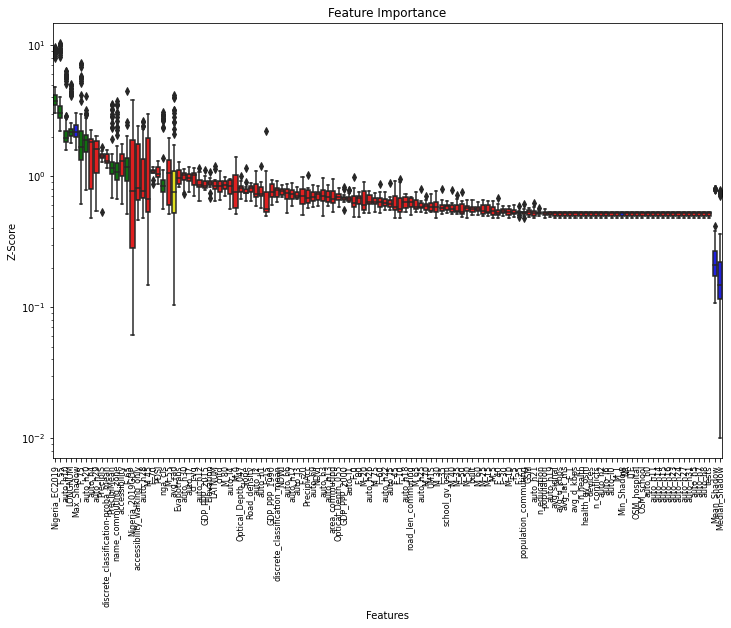

Warning there are missing values in your data !


  0%|          | 0/100 [00:00<?, ?it/s]

3 attributes confirmed important: ['LONGNUM', 'name_commuting_zone', 'PrecipiMean']
123 attributes confirmed unimportant: ['F_45', 'health_gv_osm', 'F_15', 'auto_h30', 'auto_h31', 'accessibility_walking_only', 'auto_h29', 'auto_l3', 'Optical_Depth_055', 'M_10', 'avg_rad', 'M_30', 'auto_h20', 'M_55', 'auto_h1', 'area_commuting', 'M_70', 'n_health', 'auto_h15', 'auto_h3', 'auto_l4', 'M_25', 'auto_h8', 'auto_h6', 'F_10', 'F_20', 'auto_h28', 'F_25', 'auto_h16', 'Evapotrans', 'auto_h26', 'M_80', 'Road_density', 'OSM_school', 'n_education', 'F_75', 'LTE', 'auto_h7', 'M_45', 'F_5', 'F_55', 'Nigeria_2019GDP', 'discrete_classification-proba_mean', 'F_0', 'school_gv_osm', 'avg_signal', 'PrecipiS', 'cf_cvg', 'M_5', 'auto_h17', 'M_65', 'auto_h14', 'LATNUM', 'auto_h19', 'NDVI', 'auto_h23', 'PDSI', 'avg_lat_ms', 'NR', 'auto_h22', 'road_len_commuting', 'accessibility', 'F_30', 'Nigeria_EC2019', 'M_0', 'auto_h5', 'auto_h11', 'n_conflicts', 'auto_h4', 'M_35', 'population', 'GDP_PPP_1990', 'avg_d_kbps',

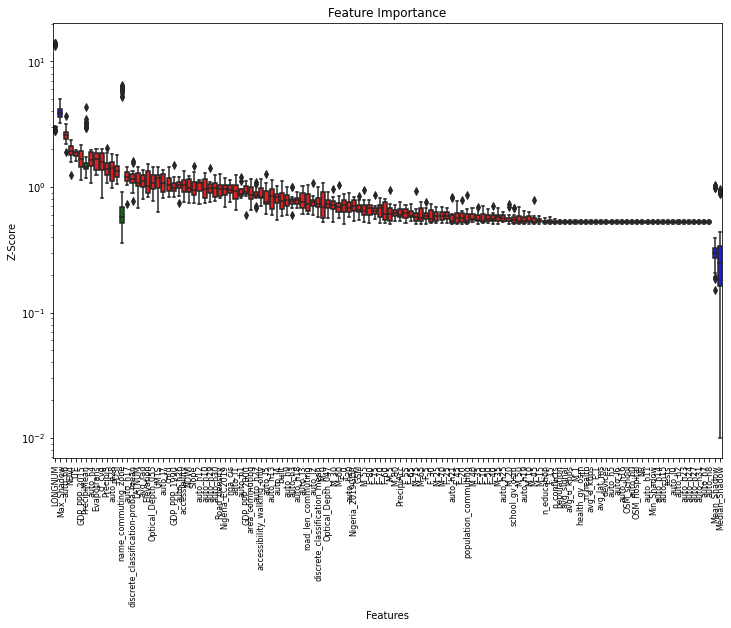

Warning there are missing values in your data !


  0%|          | 0/100 [00:00<?, ?it/s]

7 attributes confirmed important: ['F_55', 'auto_h10', 'accessibility_walking_only', 'M_80', 'Nigeria_EC2019', 'F_75', 'avg_rad']
119 attributes confirmed unimportant: ['F_45', 'health_gv_osm', 'F_15', 'auto_h30', 'auto_h31', 'auto_h29', 'auto_l3', 'Optical_Depth_055', 'M_10', 'M_30', 'auto_h20', 'M_55', 'auto_h1', 'area_commuting', 'LONGNUM', 'M_70', 'n_health', 'auto_h15', 'name_commuting_zone', 'auto_h3', 'auto_l4', 'M_25', 'auto_h8', 'auto_h6', 'F_10', 'F_20', 'auto_h28', 'PrecipiMean', 'F_25', 'auto_h16', 'Evapotrans', 'auto_h26', 'Road_density', 'OSM_school', 'n_education', 'LTE', 'auto_h7', 'M_45', 'F_5', 'Nigeria_2019GDP', 'discrete_classification-proba_mean', 'F_0', 'school_gv_osm', 'avg_signal', 'PrecipiS', 'cf_cvg', 'M_5', 'auto_h17', 'M_65', 'auto_h14', 'LATNUM', 'auto_h19', 'NDVI', 'auto_h23', 'PDSI', 'avg_lat_ms', 'NR', 'auto_h22', 'road_len_commuting', 'accessibility', 'F_30', 'M_0', 'auto_h5', 'auto_h11', 'n_conflicts', 'auto_h4', 'M_35', 'population', 'GDP_PPP_1990', '

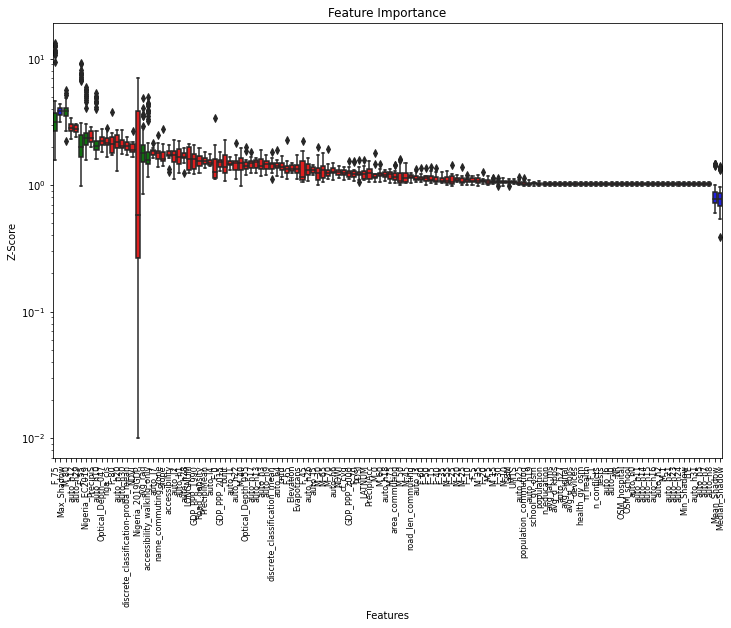

Warning there are missing values in your data !


  0%|          | 0/100 [00:00<?, ?it/s]

6 attributes confirmed important: ['M_25', 'auto_h10', 'LONGNUM', 'Nigeria_EC2019', 'name_commuting_zone', 'nga_cis']
120 attributes confirmed unimportant: ['F_45', 'health_gv_osm', 'F_15', 'auto_h30', 'auto_h31', 'accessibility_walking_only', 'auto_h29', 'auto_l3', 'Optical_Depth_055', 'M_10', 'avg_rad', 'M_30', 'auto_h20', 'M_55', 'auto_h1', 'area_commuting', 'M_70', 'n_health', 'auto_h15', 'auto_h3', 'auto_l4', 'auto_h8', 'auto_h6', 'F_10', 'F_20', 'auto_h28', 'PrecipiMean', 'F_25', 'auto_h16', 'Evapotrans', 'auto_h26', 'M_80', 'Road_density', 'OSM_school', 'n_education', 'F_75', 'LTE', 'auto_h7', 'M_45', 'F_5', 'F_55', 'Nigeria_2019GDP', 'discrete_classification-proba_mean', 'F_0', 'school_gv_osm', 'avg_signal', 'PrecipiS', 'cf_cvg', 'M_5', 'auto_h17', 'M_65', 'auto_h14', 'LATNUM', 'auto_h19', 'NDVI', 'auto_h23', 'PDSI', 'avg_lat_ms', 'NR', 'auto_h22', 'road_len_commuting', 'accessibility', 'F_30', 'M_0', 'auto_h5', 'auto_h11', 'n_conflicts', 'auto_h4', 'M_35', 'population', 'GDP_P

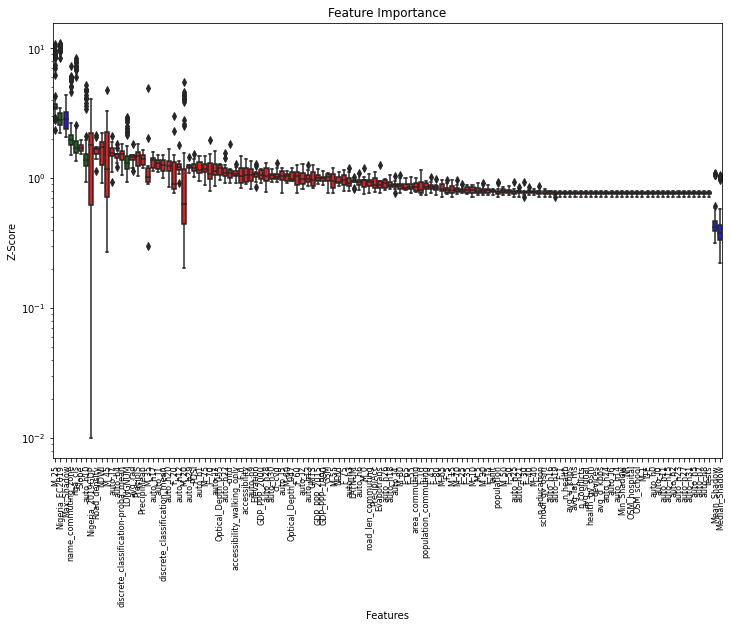

Warning there are missing values in your data !


  0%|          | 0/100 [00:00<?, ?it/s]

8 attributes confirmed important: ['GDP_PPP_1990', 'LATNUM', 'Nigeria_2019GDP', 'F_65', 'auto_h30', 'name_commuting_zone', 'avg_rad', 'PrecipiAcc']
118 attributes confirmed unimportant: ['F_45', 'health_gv_osm', 'F_15', 'auto_h31', 'accessibility_walking_only', 'auto_h29', 'auto_l3', 'Optical_Depth_055', 'M_10', 'M_30', 'auto_h20', 'M_55', 'auto_h1', 'area_commuting', 'LONGNUM', 'M_70', 'n_health', 'auto_h15', 'auto_h3', 'auto_l4', 'M_25', 'auto_h8', 'auto_h6', 'F_10', 'F_20', 'auto_h28', 'PrecipiMean', 'F_25', 'auto_h16', 'Evapotrans', 'auto_h26', 'M_80', 'Road_density', 'OSM_school', 'n_education', 'F_75', 'LTE', 'auto_h7', 'M_45', 'F_5', 'F_55', 'discrete_classification-proba_mean', 'F_0', 'school_gv_osm', 'avg_signal', 'PrecipiS', 'cf_cvg', 'M_5', 'auto_h17', 'M_65', 'auto_h14', 'auto_h19', 'NDVI', 'auto_h23', 'PDSI', 'avg_lat_ms', 'NR', 'auto_h22', 'road_len_commuting', 'accessibility', 'F_30', 'Nigeria_EC2019', 'M_0', 'auto_h5', 'auto_h11', 'n_conflicts', 'auto_h4', 'M_35', 'popu

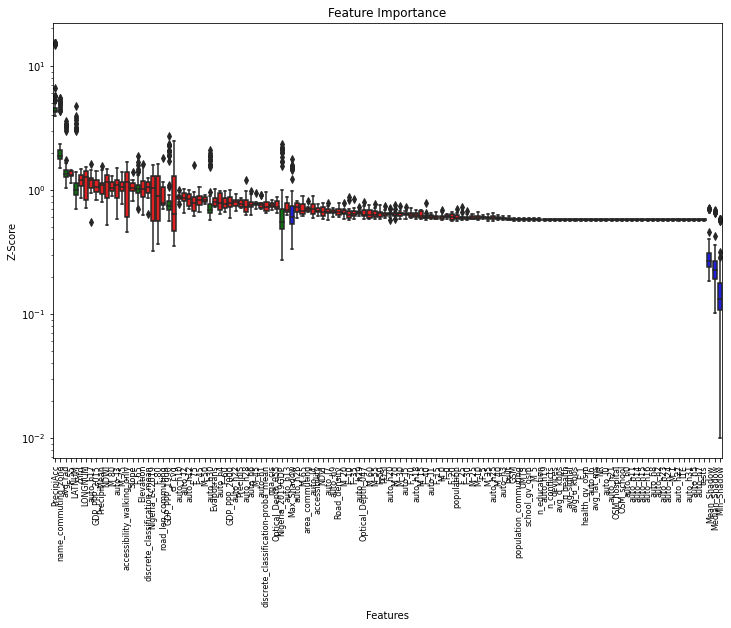

Warning there are missing values in your data !


  0%|          | 0/100 [00:00<?, ?it/s]

8 attributes confirmed important: ['auto_h10', 'M_55', 'Nigeria_EC2019', 'name_commuting_zone', 'M_20', 'F_75', 'nga_cis', 'auto_h20']
117 attributes confirmed unimportant: ['F_45', 'health_gv_osm', 'F_15', 'auto_h30', 'auto_h31', 'accessibility_walking_only', 'auto_h29', 'auto_l3', 'Optical_Depth_055', 'M_10', 'M_30', 'auto_h1', 'area_commuting', 'LONGNUM', 'M_70', 'n_health', 'auto_h15', 'auto_h3', 'auto_l4', 'M_25', 'auto_h8', 'auto_h6', 'F_10', 'auto_h28', 'F_20', 'PrecipiMean', 'F_25', 'auto_h16', 'Evapotrans', 'auto_h26', 'M_80', 'Road_density', 'OSM_school', 'n_education', 'LTE', 'auto_h7', 'M_45', 'F_5', 'F_55', 'Nigeria_2019GDP', 'discrete_classification-proba_mean', 'F_0', 'school_gv_osm', 'avg_signal', 'cf_cvg', 'PrecipiS', 'M_5', 'auto_h17', 'M_65', 'auto_h14', 'LATNUM', 'auto_h19', 'NDVI', 'auto_h23', 'PDSI', 'avg_lat_ms', 'NR', 'auto_h22', 'road_len_commuting', 'accessibility', 'F_30', 'M_0', 'auto_h5', 'auto_h11', 'n_conflicts', 'auto_h4', 'M_35', 'population', 'GDP_PPP_

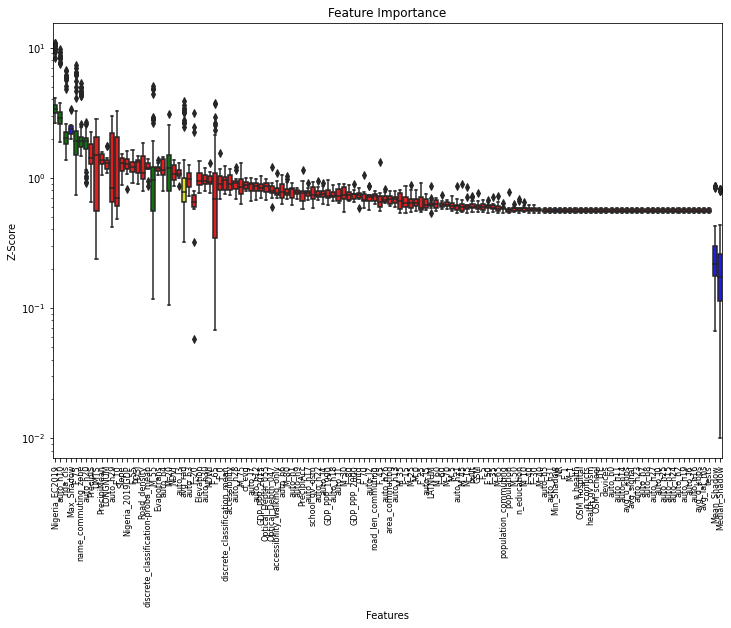

In [11]:
for name,chosen_idx in zip(good_names,good_cols):
    X_train, X_test, y_train, y_test = train_test_split(
        X, Y[chosen_idx], test_size=test_size, random_state=42
    )

    subX_train = boruta_shap_ftr_select(
        X_train,
        y_train,
        plot=True,
        n_trials=100,
        sample=False,
        train_or_test="test",
        normalize=True,
        verbose=True,
    )

# Two-stage modelling approach

In [ ]:
good_idxs


In [ ]:
inflated_vals = {
    "housing": [0],
    "water": [0, 1],
    "sanitation": [0, 1],
    "education": [0, 1],
}


In [ ]:
for chosen_idx in good_idxs:
    map_dict = {
        i: val
        for i, val in zip(
            range(len(inflated_vals[chosen_idx])), inflated_vals[chosen_idx]
        )
    }
    map_fn = lambda x: map_dict.get(x, len(inflated_vals[chosen_idx]))
    Y[f"{chosen_idx}_stg_cls"] = (
        Y[chosen_idx.join(["dep_", "_sev"])].apply(map_fn).astype("category")
    )
    # print(f"{col.mean()*100:.2f}% of {chosen_idx} are {inflated_val}")


In [ ]:
# Initialize an AutoML instance
automl = AutoML()
# Specify automl goal and constraint
automl_settings = {
    # "time_budget": 120,  # in seconds
    "metric": "micro_f1",
    "task": "classification",
    "log_file_name": "stg1_v1.log",
    "max_iter": 500,
    # "ensemble": {
    #     "final_estimator": LogisticRegressionCV(),
    #     "passthrough": False,
    # },
}
# Train with labeled input data
for chosen_idx in good_idxs:
    X_train, X_test, y_train, y_test = train_test_split(
        X, Y[f"{chosen_idx}_stg_cls"], test_size=test_size, random_state=42
    )
    mlflow.set_tracking_uri("../models/mlruns")
    mlflow.set_experiment(f"flaml-automl-{chosen_idx}-stg1")
    client = mlflow.tracking.MlflowClient()
    experiments = client.list_experiments()
    # print(experiments)
    exp_id = [
        experiment.experiment_id
        for experiment in experiments
        if experiment.name == f"flaml-automl-{chosen_idx}-stg1"
    ][0]

    with mlflow.start_run(experiment_id=exp_id) as run:
        # print(run.info.experiment_id)
        automl.fit(X_train=X_train, y_train=y_train, **automl_settings)
        # mlflow.sklearn.log_model(automl,"automl-quint")
        mlflow.log_metric(
            key="f1_score",
            value=f1_score(y_test, automl.predict(X_test), average="micro"),
        )

    preds = automl.predict(X_test)
    print(
        class_rep(
            y_test,
            preds,
        )
    )
    fig, ax = plt.subplots(dpi=150)
    hmap = sns.heatmap(conf_mat(y_test, preds), annot=True, fmt="d")
    hmap.set_xlabel("Predicted")
    hmap.set_ylabel("True")

    plt.show()


In [ ]:
automl.predict_proba(X_test).shape


In [ ]:
from stc_unicef_cpi.models.inflated_vals_2stg import InflatedValsRegressor

# from sklearn.naive_bayes import GaussianNB
# from sklearn.ensemble import HistGradientBoostingClassifier
from lightgbm import LGBMRegressor, LGBMClassifier

automl_cls = AutoML()
automl_reg = AutoML()
automl_cls_settings = {
    "metric": "micro_f1",
    "task": "classification",
    "log_file_name": "stg1_cls.log",
    "max_iter": 500,
    "estimator_list":["lgbm", "xgboost"] # if want to try others, need to impute nans
}
automl_reg_settings = {
    "metric": "rmse",
    "task": "regression",
    "log_file_name": "stg2_reg.log",
    "max_iter": 500,
    "estimator_list":["lgbm", "xgboost"]
}
# infl_vals_reg = InflatedValsRegressor(LGBMClassifier(), LGBMRegressor())
infl_vals_reg = InflatedValsRegressor(automl_cls, automl_reg)


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    X, Y[f"dep_{chosen_idx}_sev"], test_size=test_size, random_state=42
)
infl_vals_reg.fit(
    X_train,
    y_train,
    inflated_vals=inflated_vals[chosen_idx],
    cls_fit_kwargs=automl_cls_settings,
    reg_fit_kwargs=automl_reg_settings,
)


In [ ]:
infl_vals_reg.predict(X_test, weighted=True).shape


In [ ]:
from sklearn.metrics import r2_score

print(r2_score(y_test, infl_vals_reg.predict(X_test, weighted=True)))
print(r2_score(y_test, infl_vals_reg.predict(X_test, weighted=False)))


In [ ]:
plt.scatter(infl_vals_reg.predict(X_test, weighted=True), y_test)
plt.scatter(infl_vals_reg.predict(X_test), y_test)

plt.show()

In [ ]:
base_lgbm = LGBMRegressor().fit(X_train, y_train)
print(r2_score(y_test, base_lgbm.predict(X_test)))
plt.scatter(base_lgbm.predict(X_test), y_test)


# Set up as pipelines for different combs
- With / without expanded data, possibly w data extrapolated in different ways
- With / without GDP imputation of different kinds (simple / knn / rf etc.) 
- With / without standardisation (standard / robust etc.)
- With / without target transformation (e.g. log / box-cox)

In [ ]:
# try KNN imputer, speak to Arpita about more sophisticated imputers later
# resave w n_conflicts and 
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
imp = IterativeImputer(max_iter=10, random_state=42)  
from sklearn import set_config
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from flaml import AutoML
from flaml.ml import sklearn_metric_loss_score

set_config(display='diagram')

imputer = SimpleImputer()
standardiser = StandardScaler()
automl = AutoML()

automl_pipeline = Pipeline([
    ("imputer",imputer),
    ("standardiser", standardiser),
    ("automl", automl)
])
# automl_pipeline
automl_settings = {
    "time_budget": 60,  # total running time in seconds
    "metric": "mse",  # primary metrics for regression can be chosen from: ['mae','mse','r2']
    "task": "regression",  # task type
    "estimator_list": ["xgboost", "catboost", "lgbm"],
    "log_file_name": f"{comb_name}.log",  # flaml log file
    "seed": 42, # random seed
}
pipeline_settings = {
    f"automl__{key}": value for key, value in automl_settings.items()
}
automl_pipeline.fit(X_train, y_train, **pipeline_settings)

# get automl object back 
automl = automl_pipeline.steps[2][1]
# Get the best config and best learner
print('Best ML learner:', automl.best_estimator)
print('Best hyperparmeter config:', automl.best_config)
print('Best accuracy on validation data: {0:.4g}'.format(1 - automl.best_loss))
print('Training duration of best run: {0:.4g} s'.format(automl.best_config_train_time))

# plot basic feature importances  
plt.barh(automl.feature_names_in_, automl.feature_importances_)

# compute different metrics on test set 

print('r2', '=', 1 - sklearn_metric_loss_score('r2', y_pred, y_test))
print('mse', '=', sklearn_metric_loss_score('mse', y_pred, y_test))
print('mae', '=', sklearn_metric_loss_score('mae', y_pred, y_test))